In order to accurately predict which of the stocks will be in which performance category we must first do the following:
1. Get historical stock price data from the following intervals:
4 years, 2 years, 1 year, 6 months, 3 months, 1 month, current price
2. We must then get the price of a benchmark (S&P500 chosen here) for the same intervals
3. The benchmark log returns should be calculated
4. The log returns for each stock should be calculated against the benchmark
5. We must then normalize the returns with a z score
6. The scores should then be weighted and given a momentum score

After the momentum score is given to each stock we can label them as underperform, neutral, overperform based on their momentum scores.


In [440]:
import pandas as pd
import numpy as np

# First create new label based on stock performance relative to other stocks and benchmark
# Use the direct path to the file in the environment
input_file = 'sp1500_company_info_history.csv'
benchmark_input_file = 'benchmark_history.csv'
df_sp500 = pd.read_csv(benchmark_input_file)
df_raw = pd.read_csv(input_file)

benchmark_df = df_sp500[['anchor', 'close']]
benchmark_close = benchmark_df.set_index('anchor')['close'].to_dict()

# use log return - measurement of investment performance by ratio of final price to initial price
def log_return(final, initial):
    return np.log(final / initial)

# define the benchmark log returns for the S&P500 in the same windows
benchmark_returns = {
    'r_4y_2y': log_return(benchmark_close['2y'], benchmark_close['4y']),
    'r_2y_1y': log_return(benchmark_close['1y'], benchmark_close['2y']),
    'r_1y_6m': log_return(benchmark_close['6m'], benchmark_close['1y']),
    'r_6m_3m': log_return(benchmark_close['3m'], benchmark_close['6m']),
    'r_3m_1m': log_return(benchmark_close['1m'], benchmark_close['3m']),
    'r_1m_1d': log_return(benchmark_close['1d'], benchmark_close['1m'])
}

# get returns for each stock in the same windows, subtract benchmark return to get relative performance
# to benchmark
r_4y_2y = log_return(df_raw.get('2y_close'), df_raw.get('4y_close')) - benchmark_returns['r_4y_2y']
r_2y_1y = log_return(df_raw.get('1y_close'), df_raw.get('2y_close')) - benchmark_returns['r_2y_1y']
r_1y_6m = log_return(df_raw.get('6m_close'), df_raw.get('1y_close')) - benchmark_returns['r_1y_6m']
r_6m_3m = log_return(df_raw.get('3m_close'), df_raw.get('6m_close')) - benchmark_returns['r_6m_3m']
r_3m_1m = log_return(df_raw.get('1m_close'), df_raw.get('3m_close')) - benchmark_returns['r_3m_1m']
r_1m_1d = log_return(df_raw.get('currentPrice'), df_raw.get('1m_close')) - benchmark_returns['r_1m_1d']

# calculate z score for performance relative to others in each window
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean(skipna=True)
    sd = s.std(ddof=0, skipna=True)
    return (s - mu) / sd

# compute z score for all stocks
z_4y_2y = zscore(r_4y_2y)
z_2y_1y = zscore(r_2y_1y)
z_1y_6m = zscore(r_1y_6m)
z_6m_3m = zscore(r_6m_3m)
z_3m_1m = zscore(r_3m_1m)
z_1m_1d = zscore(r_1m_1d)

# now create weights dict, more weight for more recent windows apart from 1 month window
# gives momentum score, but doesn't break momentum if stock market is in a brief down cycle 
weights ={
   'z_4y_2y': 0.05,
   'z_2y_1y': 0.10,
   'z_1y_6m': 0.15,
   'z_6m_3m': 0.20,
   'z_3m_1m': 0.30,
   'z_1m_1d': 0.20
}
# create a dataframe of the z scores
z_df = pd.DataFrame({
    'z_4y_2y': z_4y_2y,
    'z_2y_1y': z_2y_1y,
    'z_1y_6m': z_1y_6m,
    'z_6m_3m': z_6m_3m,
    'z_3m_1m': z_3m_1m,
    'z_1m_1d': z_1m_1d
})

# multiply each z score by respective weights
for col, w in weights.items():
    z_df[col] = z_df[col] * w

# tracks how much weight to include for each row
# boolean mask - true for non-NaN cells -> then convert to float and multiply by weights
# this gives an actual numeric weight if cell is valid or 0.0 if cell is missing
weight_mask = pd.DataFrame({
        col: (~z_df[col].isna()).astype(float) * weights[col] for col in z_df.columns
    })

# calculate the weighted sum of all z-scores for each stock ignoring missing values
weighted_sum = z_df.sum(axis=1, skipna=True)
# now compute the actual sum of the weights used
sum_w = weight_mask.sum(axis=1)

# get the weighted average z-score, and normalize so missing data doesn't
# lower score unfairly - prevents penalizing stocks with NaN
momentum = weighted_sum / sum_w.replace(0, np.nan)

# now bin the momentum into percentile ranks
pct = momentum.rank(pct=True, method='average') 

df_with_label = df_raw.copy()
# label 0 = underperform, 1 = neurtral, 2 = outperform
df_with_label['label'] = pd.cut(pct, 
                                bins=[-np.inf, 0.33, 0.66, np.inf], 
                                labels=[0, 1, 2])

# drop na values from the label df
df_with_label = df_with_label.dropna(subset=['label']).copy()
# make the label an int, not categorical or object
df_with_label['label'] = df_with_label['label'].astype('int32')

In [441]:
# now add the new label and clean the dataframe by dropping low value columns

def clean_data(df):
    df_clean = df.copy()
    # remove columns that have no value for analysis, have large amount of
    # missing data
    drop_cols = ['companyOfficers', 'website', 'phone', 'irWebsite',
                 'longBusinessSummary', 'address1', 'tradeable', 'quoteType',
                 'language', 'region', 'quoteSourceName', 'triggerable', 
                 'customPriceAlertConfidence', 'marketState',
                 'exchangeDataDelayedBy', 'sourceInterval', 'cryptoTradeable',
                 'shortName', 'longName', 'hasPrePostMarketData',
                 'corporateActions', 'messageBoardId', 'exchangeTimezoneName',
                 'exchangeTimezoneShortName', 'gmtOffSetMilliseconds', 'fax',
                 'market', 'esgPopulated', 'address2', 'displayName',
                 'ipoExpectedDate', 'prevName', 'nameChangeDate',
                 'industrySymbol', 'prevTicker', 'tickerChangeDate',
                 'trailingPegRatio', 'lastSplitDate', 'lastSplitFactor',
                 'massive_error']

    df_clean.drop(drop_cols, inplace=True, axis=1)
    return df_clean

df_cleaned = clean_data(df_with_label)
# show label column
print(df_cleaned['label'].head(20))
# show all columns
print(df_cleaned.columns.tolist())


0     2
1     1
2     1
3     2
4     0
5     0
6     2
7     2
8     1
9     2
10    0
11    0
12    0
13    2
14    0
15    0
16    2
17    1
18    1
19    2
Name: label, dtype: int32
['city', 'state', 'zip', 'country', 'industry', 'industryKey', 'industryDisp', 'sector', 'sectorKey', 'sectorDisp', 'fullTimeEmployees', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'executiveTeam', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'allTimeHigh', 'allTimeLow', 'priceToS

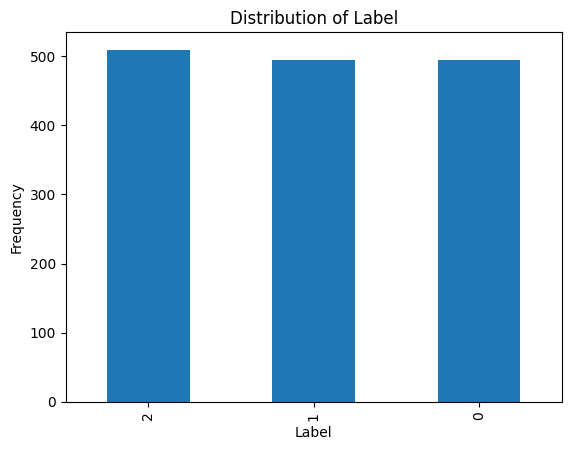

In [356]:
# plot distribution of labels
import matplotlib.pyplot as plt

# plot distribution of labels
distribution = df_cleaned['label'].value_counts()
distribution.plot.bar()
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

Classes are not imbalanced

Labels are now added to the cleaned dataframe and all unneccesary columns are removed

In [442]:
# Null values must be imputed for neural network, categorical features encoded
# first do the test train split as before

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# set random seed for tensorflow
tf.random.set_seed(90908)

features = df_cleaned.drop(columns=['label', 'symbol'])
target = df_cleaned['label']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=44)

# convert target labels to numpy array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

num_features = features.select_dtypes(include=['int64', 'float64']).columns
cat_features = features.select_dtypes(include=['object']).columns

# define a pipeline for numerical imputing and min max scaling
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])  # scale numerical features so no neg values

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# define processor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='drop'
)

# fit only on train to avoid data leakage
X_train_proc = preprocessor.fit_transform(X_train)

# use only transform on test data to prevent data leakage
# convert X_test to array to flatten for testing
X_test_proc = preprocessor.transform(X_test).toarray()


In [443]:
# build sequential model by stacking layers
model_1 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2)
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_1.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])
predictions = model_1.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())

model_1.fit(X_train_proc, y_train, epochs=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[0.00613178 0.06209067 0.         0.         0.00088454 0.0675654
 0.04888467 0.         0.2694545  0.         0.05645724 0.
 0.03171733 0.08528654 0.08528856 0.         0.1072004  0.02166194
 0.14487936 0.07446888 0.         0.         0.06086271 0.
 0.04705372 0.         0.12639278 0.1691712  0.         0.
 0.         0.         0.24086772 0.17577295 0.07900087 0.21452382
 0.02952833 0.09241572 0.00700619 0.19916382 0.01186842 0.
 0.         0.06983897 0.         0.27137876 0.11027972 0.13862216
 0.48049074 0.1872866  0.         0.         0.         0.05860898
 0.         0.15705577 0.         0.3737578  0.01878809 0.07278176
 0.07341561 0.         0.         0.28481632 0.         0.02515778
 0.06278957 0.         0.03600807 0.04134162 0.19080932 0.21243924
 0.         0.         0.         0.10456704 0.         0.
 0.21218356 0.         0.19101556 0.         0.06429161 0.
 0.15343685 0.08698475 0.         0.         0.00184721 0.03986248
 0.05043826 0.07835755 0.05206296 0.        

In [444]:
loss, accuracy = model_1.evaluate(X_test_proc, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

10/10 - 0s - 9ms/step - accuracy: 0.5333 - loss: 1.4520
Test Loss: 1.4520
Test Accuracy: 0.5333


Get the results of the first model

Now test model performance, first train model with the dense feature in the model parameter and different loss function

In [360]:
# change model to have Dense 3 for the last layer
model_2 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax') # change dense layer to 3 for 3 classes
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
predictions = model_2.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())

model_2.fit(X_train_proc, y_train, epochs=5)

loss, accuracy = model_2.evaluate(X_test_proc, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[0.36870882 0.32604998 0.30524114]
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3445 - loss: 1.0959
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5807 - loss: 0.9232
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7198 - loss: 0.6607
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8520 - loss: 0.3796
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9271 - loss: 0.2279
10/10 - 0s - 10ms/step - accuracy: 0.5433 - loss: 1.2081
Test Loss: 1.2081
Test Accuracy: 0.5433


Placing the dense layer of 3 for the 3 classifications has decreased performance

In [361]:
# use the same model as before but compile with adagrad optimizer
model_3 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax') # change dense layer to 3 for 3 classes
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense
model_3.compile(optimizer='adagrad',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
predictions = model_3.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())

model_3.fit(X_train_proc, y_train, epochs=5)

loss, accuracy = model_3.evaluate(X_test_proc, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[0.33806136 0.3237887  0.3381499 ]
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3088 - loss: 1.1091
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2753 - loss: 1.1074
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3015 - loss: 1.1006
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3425 - loss: 1.0961
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3664 - loss: 1.0967
10/10 - 0s - 10ms/step - accuracy: 0.3467 - loss: 1.0948
Test Loss: 1.0948
Test Accuracy: 0.3467


In [362]:
# use the same model as before but compile with sgd optimizer

model_4 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax') # change dense layer to 3 for 3 classes
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense
model_4.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
predictions = model_4.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())

model_4.fit(X_train_proc, y_train, epochs=5)

loss, accuracy = model_4.evaluate(X_test_proc, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[0.39207816 0.3349323  0.27298957]
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3220 - loss: 1.1149 
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3631 - loss: 1.0939
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3816 - loss: 1.0894
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4315 - loss: 1.0792
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4489 - loss: 1.0756
10/10 - 0s - 11ms/step - accuracy: 0.5100 - loss: 1.0734
Test Loss: 1.0734
Test Accuracy: 0.5100


In [363]:
# use the same model as before but compile with nadam optimizer

model_5 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax') # change dense layer to 3 for 3 classes
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense
model_5.compile(optimizer='nadam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
predictions = model_5.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())

model_5.fit(X_train_proc, y_train, epochs=5)

loss, accuracy = model_5.evaluate(X_test_proc, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[0.31244573 0.3310242  0.35653   ]
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3820 - loss: 1.0824
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5852 - loss: 0.8951
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7898 - loss: 0.5732
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9084 - loss: 0.3031
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9785 - loss: 0.1146
10/10 - 0s - 10ms/step - accuracy: 0.5967 - loss: 0.9699
Test Loss: 0.9699
Test Accuracy: 0.5967


Best results were with model 2 so we will continue with model 2 to refine the parameters used except lower dropout

In [364]:
# change dropout to 0.15 each time
model_6 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(3, activation='softmax') # change dense layer to 3 for 3 classes
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_6.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
predictions = model_6.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())

model_6.fit(X_train_proc, y_train, epochs=5)

loss, accuracy = model_6.evaluate(X_test_proc, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[0.3566345 0.2871343 0.3562313]
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3695 - loss: 1.0953
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6118 - loss: 0.9075
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7630 - loss: 0.6272
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8414 - loss: 0.4149
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9532 - loss: 0.1872
10/10 - 0s - 9ms/step - accuracy: 0.6400 - loss: 0.8539
Test Loss: 0.8539
Test Accuracy: 0.6400


In [365]:
# try with dropout of 0.25 each time
model_7 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax') # change dense layer to 3 for 3 classes
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_7.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
predictions = model_7.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())

model_7.fit(X_train_proc, y_train, epochs=5)

loss, accuracy = model_7.evaluate(X_test_proc, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[0.34310395 0.30302897 0.35386714]
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3965 - loss: 1.0862
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6073 - loss: 0.9064
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6887 - loss: 0.7052
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.4487
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9110 - loss: 0.2651
10/10 - 0s - 9ms/step - accuracy: 0.5667 - loss: 1.0319
Test Loss: 1.0319
Test Accuracy: 0.5667


Lower dropout gives higher accuracy
We will now add some new metrics before going forward with more changes to the model as it seems the performance changes quite drastically

In [366]:

# add more metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix
metric = tf.keras.metrics

model_7 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(3, activation='softmax') # change dense layer to 3 for 3 classes
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_7.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_7.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
print(predictions.flatten())
# reduce verbose to 0 so we can see all metrics in output
model_7.fit(X_train_proc, y_train, epochs=5, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_7.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_7.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[0.3353614  0.32597497 0.3386637 ]
10/10 - 0s - 43ms/step - acc: 0.5667 - loss: 1.1269 - prec_neutral: 0.6481 - prec_over: 0.6758 - prec_under: 0.7805 - rec_neutral: 0.2188 - rec_over: 0.6029 - rec_under: 0.1250 - top2_acc: 0.8267
Test Loss: 1.1269
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Macro F1: 0.5239
Weighted F1: 0.5403
              precision    recall  f1-score   support

       under       0.85      0.39      0.54       104
     neutral       0.43      0.30      0.35        83
        over       0.54      0.92      0.68       113

    accuracy                           0.57       300
   macro avg       0.61      0.54      0.52       300
weighted avg       0.62      0.57      0.54       300

[[ 41  24  39]
 [  7  25  51]
 [  0   9 104]]


With the new metrics added we can see that our model is predicting neutral for both overperform and underperform, meaning that the model is predicting neutral as a catch-all. However, the model still has an acceptable wighted F1 score and good precision for underperform and overperform. The precision for neutral is just very poor. There are a few things that can cause this: 
1. Not enough features that are discriminative
2. Recent windows are dominating causing mid-range performance to look very similar
3. Model is underfitting

We will first try to address the under fitting problem to improve performance, then we will change the window weighting and improve our feature engineering.

In [367]:
# add more epochs
model_8 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_8.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_8.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
# increase epochs to 30, reduce verbose to 0 so other output is not blocked
model_8.fit(X_train_proc, y_train, epochs=30, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_8.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_8.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 40ms/step - acc: 0.5833 - loss: 1.4450 - prec_neutral: 0.5431 - prec_over: 0.6835 - prec_under: 0.8586 - rec_neutral: 0.3938 - rec_over: 0.2647 - rec_under: 0.3320 - top2_acc: 0.8800
Test Loss: 1.4450
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Macro F1: 0.5843
Weighted F1: 0.5981
              precision    recall  f1-score   support

       under       0.66      0.64      0.65       104
     neutral       0.36      0.52      0.43        83
        over       0.81      0.58      0.67       113

    accuracy                           0.58       300
   macro avg       0.61      0.58      0.58       300
weighted avg       0.64      0.58      0.60       300

[[67 35  2]
 [27 43 13]
 [ 7 41 65]]


Model performance did not improve significantly, we will decrease epochs

In [368]:
# Decrease epochs
model_9 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_9.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_9.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
# decrease epochs to 20
model_9.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_9.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_9.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 41ms/step - acc: 0.6033 - loss: 1.3165 - prec_neutral: 0.5536 - prec_over: 0.6782 - prec_under: 0.8511 - rec_neutral: 0.3875 - rec_over: 0.2892 - rec_under: 0.3125 - top2_acc: 0.8900
Test Loss: 1.3165
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Macro F1: 0.6016
Weighted F1: 0.6164
              precision    recall  f1-score   support

       under       0.72      0.65      0.68       104
     neutral       0.37      0.51      0.43        83
        over       0.77      0.63      0.69       113

    accuracy                           0.60       300
   macro avg       0.62      0.60      0.60       300
weighted avg       0.64      0.60      0.62       300

[[68 33  3]
 [23 42 18]
 [ 4 38 71]]


Performance did not significantly change, but more epochs is likely to be less underfit so we will continue with 20 epochs but try a wider model

In [369]:
# use 20 epochs but make model wider by adding an additional layer
model_10 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_10.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_10.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_10.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_10.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_10.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 42ms/step - acc: 0.6000 - loss: 1.9483 - prec_neutral: 0.5727 - prec_over: 0.7037 - prec_under: 0.8667 - rec_neutral: 0.3938 - rec_over: 0.2794 - rec_under: 0.3555 - top2_acc: 0.8700
Test Loss: 1.9483
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.5980
Weighted F1: 0.6129
              precision    recall  f1-score   support

       under       0.70      0.70      0.70       104
     neutral       0.36      0.49      0.42        83
        over       0.80      0.58      0.68       113

    accuracy                           0.60       300
   macro avg       0.62      0.59      0.60       300
weighted avg       0.64      0.60      0.61       300

[[73 29  2]
 [28 41 14]
 [ 4 43 66]]


The performance is slightly improving by adding an additional layer, we will now try with one more additional layer but with less dropout in each layer

In [370]:
# add one more additional layer, but have less dropout for each layer
model_11 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
model_11.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_11.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_11.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_11.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_11.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
10/10 - 0s - 46ms/step - acc: 0.6067 - loss: 2.3420 - prec_neutral: 0.5250 - prec_over: 0.6786 - prec_under: 0.8617 - rec_neutral: 0.3938 - rec_over: 0.2794 - rec_under: 0.3164 - top2_acc: 0.8933
Test Loss: 2.3420
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.6081
Weighted F1: 0.6208
              precision    recall  f1-score   support

       under       0.71      0.64      0.68       104
     neutral       0.39      0.57      0.46        83
        over       0.80      0.60      0.69       113

    accuracy                           0.61       300
   macro avg       0.63      0.60      0.61       300
weighted avg       0.66      0.61      0.62       300

[[67 34  3]
 [22 47 14]
 [ 5 40 68]]


Performance with a wider model with less dropout for each layer is improved for the neutral class. We will now explore manually adjusting the learning rate for the model

In [371]:
# manually adjust learning rate
model_12 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0005)
model_12.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_12.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_12.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_12.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_12.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 43ms/step - acc: 0.6067 - loss: 1.8001 - prec_neutral: 0.5470 - prec_over: 0.6517 - prec_under: 0.8621 - rec_neutral: 0.4000 - rec_over: 0.2843 - rec_under: 0.2930 - top2_acc: 0.8767
Test Loss: 1.8001
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.6073
Weighted F1: 0.6204
              precision    recall  f1-score   support

       under       0.73      0.63      0.68       104
     neutral       0.39      0.55      0.46        83
        over       0.78      0.62      0.69       113

    accuracy                           0.61       300
   macro avg       0.63      0.60      0.61       300
weighted avg       0.65      0.61      0.62       300

[[66 33  5]
 [22 46 15]
 [ 3 40 70]]


In [372]:
# try even lower learning rate
model_13 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0004)
model_13.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_13.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_13.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_13.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_13.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
10/10 - 0s - 44ms/step - acc: 0.5833 - loss: 1.7353 - prec_neutral: 0.5760 - prec_over: 0.6835 - prec_under: 0.8478 - rec_neutral: 0.4500 - rec_over: 0.2647 - rec_under: 0.3047 - top2_acc: 0.8933
Test Loss: 1.7353
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.5866
Weighted F1: 0.5976
              precision    recall  f1-score   support

       under       0.69      0.62      0.65       104
     neutral       0.38      0.58      0.46        83
        over       0.79      0.56      0.65       113

    accuracy                           0.58       300
   macro avg       0.62      0.58      0.59       300
weighted avg       0.64      0.58      0.60       300

[[64 35  5]
 [23 48 12]
 [ 6 44 63]]


Weighted F1 did not improve, We will continue to try lower learning rates

In [373]:
# try even lower learning rate
model_14 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_14.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_14.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_14.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_14.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_14.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 42ms/step - acc: 0.6300 - loss: 1.0455 - prec_neutral: 0.5234 - prec_over: 0.6562 - prec_under: 0.8488 - rec_neutral: 0.3500 - rec_over: 0.3088 - rec_under: 0.2852 - top2_acc: 0.9100
Test Loss: 1.0455
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.6261
Weighted F1: 0.6413
              precision    recall  f1-score   support

       under       0.75      0.63      0.69       104
     neutral       0.40      0.53      0.46        83
        over       0.77      0.70      0.73       113

    accuracy                           0.63       300
   macro avg       0.64      0.62      0.63       300
weighted avg       0.66      0.63      0.64       300

[[66 34  4]
 [20 44 19]
 [ 2 32 79]]


Try different activation types in layers to see if there are changes

In [374]:
activation_leaky = tf.keras.layers.LeakyReLU

model_15 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Dense(512, kernel_initializer='he_normal', input_shape=(X_train_proc.shape[1],)),
    activation_leaky(alpha=0.01),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.01),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.01),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.01),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0004)
model_15.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_15.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_15.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_15.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_15.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


10/10 - 0s - 42ms/step - acc: 0.6000 - loss: 1.6636 - prec_neutral: 0.5526 - prec_over: 0.7125 - prec_under: 0.8614 - rec_neutral: 0.3938 - rec_over: 0.2794 - rec_under: 0.3398 - top2_acc: 0.9067
Test Loss: 1.6636
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.5998
Weighted F1: 0.6134
              precision    recall  f1-score   support

       under       0.68      0.66      0.67       104
     neutral       0.38      0.53      0.44        83
        over       0.82      0.59      0.69       113

    accuracy                           0.60       300
   macro avg       0.62      0.60      0.60       300
weighted avg       0.65      0.60      0.61       300

[[69 32  3]
 [27 44 12]
 [ 6 40 67]]


Performance slightly decreased so we will attempt again with slightly higher alpha

In [375]:
# attempt with slightly higher alpha
model_16 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Dense(512, kernel_initializer='he_normal', input_shape=(X_train_proc.shape[1],)),
    activation_leaky(alpha=0.02),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.02),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.02),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.02),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0004)
model_16.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_16.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_16.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_16.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_16.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
10/10 - 0s - 46ms/step - acc: 0.6167 - loss: 1.5955 - prec_neutral: 0.5849 - prec_over: 0.6552 - prec_under: 0.8627 - rec_neutral: 0.3875 - rec_over: 0.2794 - rec_under: 0.3438 - top2_acc: 0.8800
Test Loss: 1.5955
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1: 0.6128
Weighted F1: 0.6269
              precision    recall  f1-score   support

       under       0.68      0.67      0.68       104
     neutral       0.40      0.52      0.45        83
        over       0.80      0.64      0.71       113

    accuracy                           0.62       300
   macro avg       0.63      0.61      0.61       300
weighted avg       0.65      0.62      0.63       300

[[70 29  5]
 [27 43 13]
 [ 6 35 72]]


Performance improved compared to the same activation, will try slightly higher alpha again

In [376]:
# attempt with slightly higher alpha
model_17 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Dense(512, kernel_initializer='he_normal', input_shape=(X_train_proc.shape[1],)),
    activation_leaky(alpha=0.022),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.022),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.022),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal'),
    activation_leaky(alpha=0.022),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0004)
model_17.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_17.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_17.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_17.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_17.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
10/10 - 0s - 47ms/step - acc: 0.5933 - loss: 1.7089 - prec_neutral: 0.5431 - prec_over: 0.6552 - prec_under: 0.8632 - rec_neutral: 0.3938 - rec_over: 0.2794 - rec_under: 0.3203 - top2_acc: 0.8800
Test Loss: 1.7089
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1: 0.5929
Weighted F1: 0.6079
              precision    recall  f1-score   support

       under       0.69      0.63      0.66       104
     neutral       0.36      0.51      0.42        83
        over       0.80      0.62      0.70       113

    accuracy                           0.59       300
   macro avg       0.62      0.59      0.59       300
weighted avg       0.64      0.59      0.61       300

[[66 36  2]
 [25 42 16]
 [ 5 38 70]]


Performance is worse, overall not much difference with this activation method so we will attempt to use a different one

In [377]:
model_18 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='gelu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='gelu'),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='gelu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_18.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_18.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_18.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_18.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_18.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 46ms/step - acc: 0.6000 - loss: 1.4136 - prec_neutral: 0.5778 - prec_over: 0.6979 - prec_under: 0.8358 - rec_neutral: 0.4875 - rec_over: 0.3284 - rec_under: 0.2188 - top2_acc: 0.9333
Test Loss: 1.4136
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Macro F1: 0.6036
Weighted F1: 0.6158
              precision    recall  f1-score   support

       under       0.79      0.52      0.63       104
     neutral       0.38      0.63      0.47        83
        over       0.77      0.65      0.71       113

    accuracy                           0.60       300
   macro avg       0.65      0.60      0.60       300
weighted avg       0.67      0.60      0.62       300

[[54 45  5]
 [14 52 17]
 [ 0 39 74]]


Performance is the same as relu, we will try adding some regularization and normalization instead

In [378]:
model_19 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(5e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(5e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(5e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(5e-4)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_19.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_19.predict(X_train_proc[:1])
tf.nn.softmax(predictions)
model_19.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_19.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_19.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 46ms/step - acc: 0.6567 - loss: 1.3134 - prec_neutral: 0.6000 - prec_over: 0.6696 - prec_under: 0.8511 - rec_neutral: 0.3000 - rec_over: 0.3775 - rec_under: 0.3125 - top2_acc: 0.8967
Test Loss: 1.3134
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1: 0.6413
Weighted F1: 0.6578
              precision    recall  f1-score   support

       under       0.73      0.67      0.70       104
     neutral       0.45      0.47      0.46        83
        over       0.75      0.78      0.77       113

    accuracy                           0.66       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.66      0.66      0.66       300

[[70 28  6]
 [21 39 23]
 [ 5 20 88]]


Adding regularization improved the results across the board, we will attempt with an even higher regularization parameter

In [379]:
model_20 = tf.keras.models.Sequential([
    # added l2 regularizer
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_20.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_20.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

model_20.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_20.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_20.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 44ms/step - acc: 0.6633 - loss: 1.4176 - prec_neutral: 0.5588 - prec_over: 0.6458 - prec_under: 0.8586 - rec_neutral: 0.3562 - rec_over: 0.3039 - rec_under: 0.3320 - top2_acc: 0.9333
Test Loss: 1.4176
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.6575
Weighted F1: 0.6728
              precision    recall  f1-score   support

       under       0.75      0.72      0.74       104
     neutral       0.43      0.54      0.48        83
        over       0.82      0.70      0.76       113

    accuracy                           0.66       300
   macro avg       0.67      0.65      0.66       300
weighted avg       0.69      0.66      0.67       300

[[75 28  1]
 [22 45 16]
 [ 3 31 79]]


The L2 regularizer with an even higher regularization has further improved the performance, we will again increase regularization

In [380]:
model_21 = tf.keras.models.Sequential([
    # added l2 regularizer
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_21.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_21.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

model_21.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_21.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_21.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 46ms/step - acc: 0.6933 - loss: 1.4443 - prec_neutral: 0.5652 - prec_over: 0.6535 - prec_under: 0.8553 - rec_neutral: 0.3250 - rec_over: 0.4069 - rec_under: 0.2539 - top2_acc: 0.8933
Test Loss: 1.4443
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1: 0.6780
Weighted F1: 0.6933
              precision    recall  f1-score   support

       under       0.82      0.61      0.70       104
     neutral       0.49      0.55      0.52        83
        over       0.77      0.88      0.82       113

    accuracy                           0.69       300
   macro avg       0.69      0.68      0.68       300
weighted avg       0.71      0.69      0.69       300

[[63 34  7]
 [14 46 23]
 [ 0 14 99]]


Performance is improved even more, we will try an even higher regularization now

In [381]:
model_22 = tf.keras.models.Sequential([
    # added l2 regularizer
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(2e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(2e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(2e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(2e-3)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_22.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_22.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

model_22.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_22.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_22.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
10/10 - 0s - 46ms/step - acc: 0.6767 - loss: 1.5913 - prec_neutral: 0.6296 - prec_over: 0.6636 - prec_under: 0.8646 - rec_neutral: 0.3187 - rec_over: 0.3578 - rec_under: 0.3242 - top2_acc: 0.9300
Test Loss: 1.5913
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.6601
Weighted F1: 0.6778
              precision    recall  f1-score   support

       under       0.76      0.71      0.73       104
     neutral       0.45      0.47      0.46        83
        over       0.78      0.80      0.79       113

    accuracy                           0.68       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.68      0.68      0.68       300

[[74 26  4]
 [22 39 22]
 [ 2 21 90]]


The sweet spot seems to be l2 regularization of 1e-3, so we will go forward with that and attempt to further widen the model

In [382]:
model_23 = tf.keras.models.Sequential([
    # added l2 regularizer
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_23.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_23.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

model_23.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_23.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_23.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
10/10 - 0s - 47ms/step - acc: 0.6533 - loss: 1.6333 - prec_neutral: 0.5776 - prec_over: 0.6476 - prec_under: 0.8356 - rec_neutral: 0.4187 - rec_over: 0.3333 - rec_under: 0.2383 - top2_acc: 0.9267
Test Loss: 1.6333
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1: 0.6489
Weighted F1: 0.6643
              precision    recall  f1-score   support

       under       0.77      0.56      0.65       104
     neutral       0.42      0.60      0.50        83
        over       0.83      0.78      0.80       113

    accuracy                           0.65       300
   macro avg       0.67      0.65      0.65       300
weighted avg       0.70      0.65      0.66       300

[[58 44  2]
 [17 50 16]
 [ 0 25 88]]


Adding an additional layer does not improve the model, we will remove the layer and begin to look at more feature engineering

In [383]:
model_20 = tf.keras.models.Sequential([
    # added l2 regularizer
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_20.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_20.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

model_20.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_20.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_20.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 46ms/step - acc: 0.6733 - loss: 1.3674 - prec_neutral: 0.5698 - prec_over: 0.6475 - prec_under: 0.8471 - rec_neutral: 0.3063 - rec_over: 0.3873 - rec_under: 0.2812 - top2_acc: 0.9233
Test Loss: 1.3674
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.6554
Weighted F1: 0.6729
              precision    recall  f1-score   support

       under       0.78      0.63      0.70       104
     neutral       0.45      0.48      0.47        83
        over       0.76      0.85      0.80       113

    accuracy                           0.67       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.68      0.67      0.67       300

[[66 32  6]
 [18 40 25]
 [ 1 16 96]]


We have exhausted our efforts with adjusting the architecture and paramater tuning of our neural network so now we need to look at feature engineering.
We will begin by adding some features and creating new features

In [435]:
# add distance to 52 week extremes
rng = (df_with_label['fiftyTwoWeekHigh'] - df_with_label['fiftyTwoWeekLow']).replace(0, np.nan)
df_with_label['pos_in_52w'] = (df_with_label['currentPrice'] - df_with_label['fiftyTwoWeekLow']) / (rng + 1e-9)

# add simple volume surge ratios
df_with_label['vol_surge_now_3m']  = df_with_label['volume'] / (df_with_label['averageDailyVolume3Month'] + 1e-9)
df_with_label['vol_surge_now_10d'] = df_with_label['volume'] / (df_with_label['averageVolume10days'] + 1e-9)
df_with_label['vol_surge_1m_3m']   = df_with_label['1m_volume'] / (df_with_label['averageDailyVolume3Month'] + 1e-9)

# add distance to moving averages
df_with_label['dist_ma50']  = (df_with_label['currentPrice'] - df_with_label['fiftyDayAverage']) / (df_with_label['fiftyDayAverage'] + 1e-9)
df_with_label['dist_ma200'] = (df_with_label['currentPrice'] - df_with_label['twoHundredDayAverage']) / (df_with_label['twoHundredDayAverage'] + 1e-9)
df_with_label['ma_cross']   = (df_with_label['fiftyDayAverage'] - df_with_label['twoHundredDayAverage']) / (df_with_label['twoHundredDayAverage'] + 1e-9)

df_new_labels = df_with_label[['currentPrice', 'fiftyDayAverage', 'twoHundredDayAverage','dist_ma50', 'dist_ma200', 'ma_cross']].head(5)
print(df_new_labels.to_string(index=False))

# add liquidity size, shares outstanding ratios
df_with_label['log_mcap']  = np.log(df_with_label['marketCap'] + 1)
# high outstanding shares = lots of flots is short and performance may be poor
df_with_label['float_to_out'] = df_with_label['floatShares'] / (df_with_label['sharesOutstanding'] + 1e-9)

# add z scores to the table for neural net to see each z score
df_with_label['z_4y_2y'] = z_4y_2y
df_with_label['z_2y_1y'] = z_2y_1y
df_with_label['z_1y_6m'] = z_1y_6m
df_with_label['z_6m_3m'] = z_6m_3m
df_with_label['z_3m_1m'] = z_3m_1m
df_with_label['z_1m_1d'] = z_1m_1d



df_cleaned = clean_data(df_with_label)

# reprocess
features = df_cleaned.drop(columns=['label', 'symbol'])
target = df_cleaned['label']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=44)

# convert target labels to numpy array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

num_features = features.select_dtypes(include=['int64', 'float64']).columns
cat_features = features.select_dtypes(include=['object']).columns

# define a pipeline for numerical imputing and min max scaling
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])  # scale numerical features so no neg values

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# define processor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='drop'
)

# fit only on train to avoid data leakage
X_train_proc = preprocessor.fit_transform(X_train)

# use only transform on test data to prevent data leakage
# convert X_test to array to flatten for testing
X_test_proc = preprocessor.transform(X_test).toarray()

 currentPrice  fiftyDayAverage  twoHundredDayAverage  dist_ma50  dist_ma200  ma_cross
       166.50         157.2214             150.05576   0.059016    0.109588  0.047753
        65.99          71.1404              68.28100  -0.072398   -0.033553  0.041877
       123.62         131.4586             130.89246  -0.059628   -0.055561  0.004325
       218.04         222.3706             199.54900  -0.019475    0.092664  0.114366
       250.10         246.7902             296.32050   0.013411   -0.155981 -0.167151


In [385]:
# train neural net with new data
model_24 = tf.keras.models.Sequential([
    # added l2 regularizer
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(8e-4)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(3, activation='softmax')
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0001)
model_24.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_24.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

model_24.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_24.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_24.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 0s - 48ms/step - acc: 0.7333 - loss: 1.2003 - prec_neutral: 0.5368 - prec_over: 0.6549 - prec_under: 0.8523 - rec_neutral: 0.3187 - rec_over: 0.3627 - rec_under: 0.2930 - top2_acc: 0.9700
Test Loss: 1.2003
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1: 0.7235
Weighted F1: 0.7379
              precision    recall  f1-score   support

       under       0.83      0.71      0.77       104
     neutral       0.53      0.61      0.57        83
        over       0.83      0.84      0.84       113

    accuracy                           0.73       300
   macro avg       0.73      0.72      0.72       300
weighted avg       0.75      0.73      0.74       300

[[74 29  1]
 [14 51 18]
 [ 1 17 95]]


With these additional features we see a huge improvement in the weighted F1 score due to a big increase in precision of both underperformers and neutral classes. However, the neutral class is still struggling the most.
We will now try to tune the model one last time with trying logits + from_logits=True for our loss

In [439]:
# train neural net with new data
tf.random.set_seed(5005)
model_25 = tf.keras.models.Sequential([
    # added l2 regularizer
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.Dropout(0.05)
])

# put together NN with training process, loss, and means of evaluation
# use loss of sparse categorical crossentropy since Dense is in layer
# adjust learning rate in optimizer manually to have slower learning rate
optimizer =  tf.keras.optimizers.Adam(learning_rate=0.0005)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_25.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_25.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

model_25.fit(X_train_proc, y_train, epochs=20, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, 
 prec_under, rec_under, 
 prec_neutral, rec_neutral, 
 prec_over, rec_over) = model_25.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_25.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/Users/brendantorok/Documents/Schooling/BU MET/CS767 - Advanced Machine Learning/Assignments/Assignment 2/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 - 1s - 52ms/step - acc: 0.7233 - loss: 1.4968 - prec_neutral: 0.5324 - prec_over: 0.6667 - prec_under: 0.8392 - rec_neutral: 0.9250 - rec_over: 0.6176 - rec_under: 0.6523 - top2_acc: 0.9667
Test Loss: 1.4968
Test Accuracy: 0.5667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1: 0.7167
Weighted F1: 0.7292
              precision    recall  f1-score   support

       under       0.75      0.87      0.80       104
     neutral       0.51      0.63      0.57        83
        over       0.95      0.66      0.78       113

    accuracy                           0.72       300
   macro avg       0.74      0.72      0.72       300
weighted avg       0.76      0.72      0.73       300

[[90 14  0]
 [27 52  4]
 [ 3 35 75]]


We will now use this final model to predict class probabilities and rank overperform probability to get the stocks most likely to overperform in the future

In [427]:
# save final manual model
import joblib
model_25.save("nn_model_outperf.h5")
joblib.dump(preprocessor, "preprocessor.pkl")

final_model = tf.keras.models.load_model('nn_model_outperf.h5')
preproc = joblib.load("preprocessor.pkl")

df_live = df_cleaned.copy()
X_live = preproc.transform(df_live).toarray()

# predict probabilities over classes
probs = tf.nn.softmax(final_model.predict(X_live), axis=1).numpy()
p_under, p_neut, p_over = probs[:,0], probs[:,1], probs[:,2]

# rank the scores
df_live['p_over'] = p_over
# get margin that p_over is greater than the next greatest probability
df_live['margin_over_vs_next'] = p_over - np.maximum(p_neut, p_under)
# get the confidence interval
df_live['confidence'] = df_live[['p_over', 'margin_over_vs_next']].mean(axis=1)

# selection rules

p_threshold = 0.60
stock_picks = df_live.loc[df_live['p_over'] >= p_threshold].copy()
top_20 = stock_picks.sort_values('confidence', ascending=False).head(20)

# print the top 20 and some key metrics
print(top_20[['symbol', 'p_over', 'confidence', 'recommendationKey', 'currentPrice', 'forwardPE']])




47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
     symbol    p_over  confidence recommendationKey  currentPrice   forwardPE
398    HOOD  1.000000    1.000000               buy        146.78  201.068480
604    CYTK  1.000000    1.000000               buy         63.59  -11.797774
1397   SNDK  1.000000    1.000000               buy        199.33   19.709223
358    PLTR  1.000000    1.000000              hold        200.47  426.531920
314      MU  1.000000    1.000000               buy        223.77   17.386948
490     WDC  1.000000    1.000000               buy        150.21   17.049944
643     FIX  1.000000    1.000000        strong_buy        965.58   56.832256
40      APP  1.000000    1.000000               buy        637.33  123.513570
710    KTOS  0.999999    0.999999              none         90.60  153.559330
957    ARWR  0.999999    0.999999               buy         42.39  -10.045024
1442   TTMI  0.999998    0.999998        strong_buy         67.20   34.111670
1471   VSAT  0.999998    

Compare results to the first model
Rewrite first model to add all metrics

In [445]:
# MUST RE RUN BEGINNING CODE BLOCKS FOR ORIGINAL DATAFRAME AND SPLIT BEFORE NEW FEATURE ENGINEERING FOR THIS TO WORK
model_1 = tf.keras.models.Sequential([
    # shape should be based on the shape of the train dense matrix
    tf.keras.layers.Flatten(input_shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2)
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# use the same model except add metrics
model_1.compile(optimizer='adam',
                loss=loss_fn,
                metrics=[metric.SparseCategoricalAccuracy(name='acc'),
                         metric.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
                         # per class percision and recall
                         metric.Precision(name='prec_under', class_id=0),
                         metric.Recall(name='rec_under', class_id=0),
                         metric.Precision(name='prec_neutral', class_id=1),
                         metric.Recall(name='rec_neutral', class_id=1),
                         metric.Precision(name='prec_over', class_id=2),
                         metric.Recall(name='rec_over', class_id=2)
                         ])
predictions = model_1.predict(X_train_proc[:1])
tf.nn.softmax(predictions)

# change verbose to be 0 so we can see the whole output
model_1.fit(X_train_proc, y_train, epochs=5, verbose=0)

# get the evaluation metrics from the model
(loss, acc, top2_acc, prec_under, rec_under, prec_neutral, rec_neutral, prec_over, rec_over) = model_1.evaluate(X_test_proc, y_test, verbose=2)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

probs = model_1.predict(X_test_proc)
pred = probs.argmax(1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(classification_report(y_test, pred, target_names=['under', 'neutral', 'over']))
print(confusion_matrix(y_test, pred))


# save the model and print the chart
model_1.save("nn__first_model_outperf.h5")
joblib.dump(preprocessor, "preprocessor.pkl")

first_model = tf.keras.models.load_model('nn__first_model_outperf.h5')
preproc = joblib.load("preprocessor.pkl")

df_live = df_cleaned.copy()
X_live = preproc.transform(df_live).toarray()

# predict probabilities over classes
probs = tf.nn.softmax(first_model.predict(X_live), axis=1).numpy()
p_under, p_neut, p_over = probs[:,0], probs[:,1], probs[:,2]

# rank the scores
df_live['p_over'] = p_over
df_live['margin_over_vs_next'] = p_over - np.maximum(p_neut, p_under)
df_live['confidence'] = df_live[['p_over', 'margin_over_vs_next']].mean(axis=1)

# selection rules

p_threshold = 0.60
stock_picks = df_live.loc[df_live['p_over'] >= p_threshold].copy()
top_20 = stock_picks.sort_values('confidence', ascending=False).head(20)

# print the top 20 and some key metrics
print(top_20[['symbol', 'p_over', 'confidence', 'recommendationKey', 'currentPrice', 'forwardPE']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
10/10 - 0s - 47ms/step - acc: 0.5833 - loss: 1.2834 - prec_neutral: 0.5333 - prec_over: 0.6800 - prec_under: 0.8528 - rec_neutral: 1.0000 - rec_over: 1.0000 - rec_under: 0.9961 - top2_acc: 0.9100
Test Loss: 1.2834
Test Accuracy: 0.5333
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Macro F1: 0.5871
Weighted F1: 0.5958
              precision    recall  f1-score   support

       under       0.67      0.62      0.64       104
     neutral       0.39      0.63      0.48        83
        over       0.81      0.52      0.63       113

    accuracy                           0.58       300
   macro avg       0.63      0.59      0.59       300
weighted avg       0.65      0.58      0.60       300

[[64 36  4]
 [21 52 10]
 [10 44 59]]
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
     symbol    p_over  confidence recommendationKey  currentPrice   forwardPE
604    CYTK  0.999844    0.999770               buy         63.59  -11.797774
345    NVDA  0.980852    0.976486        strong_buy        202.49   49.148060
358    PLTR  0.936363    0.928822              hold        200.47  426.531920
398    HOOD  0.907381    0.897331               buy        146.78  201.068480
22     AMZN  0.910354    0.894481        strong_buy        244.22   39.710567
1397   SNDK  0.894196    0.887519    

In [402]:
print('p over and margin over next')
print(top_20[['symbol', 'p_over', 'margin_over_vs_next']].head(5))
print(top_20[['symbol', 'confidence']].head(5))

p over and margin over next
     symbol    p_over  margin_over_vs_next
604    CYTK  0.998080             0.996282
345    NVDA  0.966754             0.960818
1397   SNDK  0.915854             0.904881
398    HOOD  0.905623             0.890312
643     FIX  0.903497             0.886419
     symbol  confidence
604    CYTK    0.997181
345    NVDA    0.963786
1397   SNDK    0.910367
398    HOOD    0.897967
643     FIX    0.894958


Rerun code to get new features back into test train split
We will now get a figure of the training curve

In [417]:
# store model fit in history variable
history = model_25.fit(X_train_proc, y_train, epochs=20,verbose=1,
                       validation_data=(X_test_proc, y_test))


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.9492 - loss: 0.4347 - prec_neutral: 0.7151 - prec_over: 0.6916 - prec_under: 0.5267 - rec_neutral: 0.7088 - rec_over: 0.5465 - rec_under: 0.4736 - top2_acc: 0.9841 - val_acc: 0.7767 - val_loss: 1.1724 - val_prec_neutral: 0.5417 - val_prec_over: 0.6524 - val_prec_under: 0.8453 - val_rec_neutral: 0.7312 - val_rec_over: 0.5245 - val_rec_under: 0.5977 - val_top2_acc: 0.9800
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9598 - loss: 0.3889 - prec_neutral: 0.7031 - prec_over: 0.6861 - prec_under: 0.5216 - rec_neutral: 0.7186 - rec_over: 0.5585 - rec_under: 0.4857 - top2_acc: 0.9824 - val_acc: 0.7500 - val_loss: 1.2076 - val_prec_neutral: 0.5336 - val_prec_over: 0.6474 - val_prec_under: 0.8444 - val_rec_neutral: 0.7437 - val_rec_over: 0.4951 - val_rec_under: 0.5938 - val_top2_acc: 0.9833
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9539 - loss: 0.4180 - prec_neutral: 0.7132 - prec_over: 0.6947 - prec_unde

Create graph for epochs

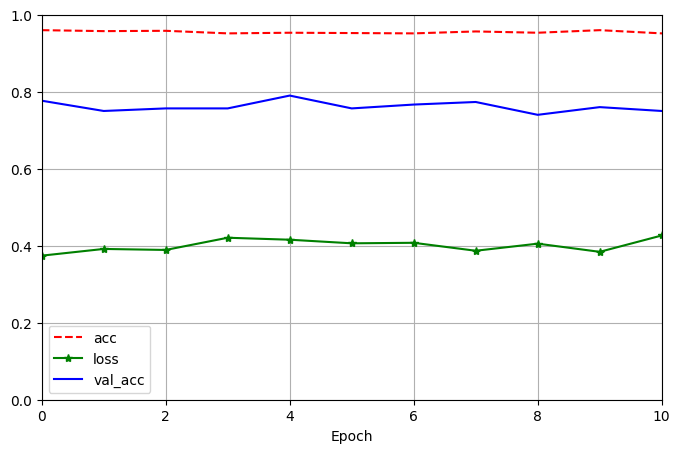

In [428]:
pd.DataFrame(history.history)[['acc', 'loss', 'val_acc']].plot(
    figsize=(8, 5), xlim=[0, 10], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=["r--", "g*-", "b-", "b-*"]
)
plt.show()